In [1]:
# libraries used
import numpy as np
import pandas as pd
import time

# from sklearn.model_selection import train_test_split  ??
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# importing the training data set, we will only use the real values of meteorological values to train the models (years 2015-2018)
data = pd.read_csv('reanalysis_merged_3hourMean.csv')

In [3]:
# importing the testing data set, we will use only the data from 2018 to test the data set
testing_data = pd.read_csv('ensembleMean_merged.csv')

First of all, we split the data set into training and testing in order to get a higher precision of metrics. 

The training part includes the electricity data before year 2018 while the testing set includes the electricity data after 2018. 

In [4]:
# splitting data set into training set and testing set (OUTER)

train = data[data['time']<'2018-01-01 00:00:00']                    # trainig set are data from dates before 2018
test = testing_data[testing_data['time']>='2018-01-01 00:00:00']    # testing set are data from dates after 2018

In [5]:
# splitting the sets into variables and response
y_train = train['response'].values
x_train = train[[x for x in train.columns if (x != 'response') & (x != 'time')]].values

y_test = test['response'].values
x_test = test[[x for x in test.columns if (x != 'response') & (x != 'time')]].values

Then we split the training part into training set and validation set in order to set a custom cross validation method. 

The reason to do so is, it is only possible to use the previous data to predict the future, therefore, we split the data into 3 different times to train the different models. 
- dates before 2017 as the training set;
- dates from 2017-2018 as the validation set (in order to tune the hyperparameters of each single model that we will be using in the project); 
- and the dates after 2018 as the testing set (in order to compare the different metrics for each model that we have trained) 

In [6]:
# checking the index that contains the data set after 2017

train[train['time']=='2017-01-01 00:00:00']

,norma_10_36.0_-5.0,norma_10_36.0_-5.5,norma_10_36.0_-6.0,norma_10_36.0_-6.5,norma_10_36.5_-5.0,norma_10_36.5_-5.5,norma_10_36.5_-6.0,norma_10_36.5_-6.5,norma_10_37.0_-5.0,norma_10_37.0_-5.5,...,v100_36.5_-5.0,v100_36.5_-5.5,v100_36.5_-6.0,v100_36.5_-6.5,v100_37.0_-5.0,v100_37.0_-5.5,v100_37.0_-6.0,v100_37.0_-6.5,response,time
5844,7.842567,6.550414,8.525476,9.255894,3.968029,2.951772,3.973586,6.267064,2.63335,1.817965,...,0.31519,2.679534,2.146031,1.244911,5.317875,2.941709,0.066172,0.022889,1321.554,2017-01-01 00:00:00


In [7]:
# Splitting indeces to create a custom cv 

train_indices = list(range(0,5844))                  # dates before 2017 are used to train
test_indices = list(range(5844, len(train)))         # dates from 2017 to 2018 to validate (INNER)
custom_cv = [(train_indices, test_indices)]

### Defining different functions to ease the process

During the project, we will be using three most popular methods which are the as the followings: 
1. Random Forest
2. Gradient Boosting
3. Support Vector Machines

We define different functions in order to facilitate the process of training part, by using these functions, it is only necessary to give three arguments: 
1. Training set
2. Testing set 
3. The different values that we want to tune for the hyperparameters

In [8]:
# 1. Random forest
def optimize_rf(x_train, y_train, params_rf):
    rf=RandomForestRegressor(random_state = 10)
    rf_search = RandomizedSearchCV(rf, params_rf, cv=custom_cv, n_iter = 30)
    rf_search.fit(x_train, y_train)
    return rf_search.best_estimator_

In [9]:
# 2. Gradient boosting
def optimize_gb(x_train, y_train, params_gb):
    gb=GradientBoostingRegressor(random_state = 10)
    gb_search = RandomizedSearchCV(gb, params_gb, cv=custom_cv, n_iter = 30)
    gb_search.fit(x_train, y_train)
    return gb_search.best_estimator_

In [10]:
# 3. SVM
def optimize_svm(x_train, y_train, params_svm):   
    svm = SVR()
    svm_search = RandomizedSearchCV(svm, params_svm, cv=custom_cv, n_iter = 30)
    svm_search.fit(x_train, y_train)
    return svm_search.best_estimator_

With the intention of visualization of the different results of metrics per model, we create a matrix that displays all the results of each model per each data set that we modify. 


Also, it is necessary to create a function that automatically does the imputation in the matrix for us. 

The function made requires 5 arguments: the true reponse (y element) for training set and testing set; the prediction of the response that the different models have made and the name of the model. 

In [11]:
# creating a metrics matrix in order to visualize the different results
df_metricas=pd.DataFrame(columns=['train_R2', 'test_R2', 'train_MAXerror', 'test_MAXerror',
                                 'train_mae', 'test_mae', 'train_mse', 'test_mse', 
                                  'train_rmse', 'test_rmse'], 
                         index=['RF_all','GB_all','SVM_all', 'lm_all',
                                'RF_uv','GB_uv','SVM_uv', 'lm_uv',
                                'RF_module','GB_module','SVM_module', 'lm_module'])

In [12]:
# Metrics for evaluating
def metrics(y_train, pred_train, y_test, pred_test, model):
    # Varianza explicada
    ve_train = explained_variance_score(y_train, pred_train)
    ve_test = explained_variance_score(y_test, pred_test)
    print('explained variance of training set:',(ve_train))
    print('explained variance of testing set:',(ve_test))
    df_metricas.loc[model, 'train_R2']=ve_train
    df_metricas.loc[model, 'test_R2']=ve_test
    # Maximum error
    me_train = max_error(pred_train, y_train)
    me_test = max_error(pred_test, y_test)
    print('maximum error of training set:',(me_train))
    print('maximum error of testing set:',(me_test))
    df_metricas.loc[model, 'train_MAXerror']=me_train
    df_metricas.loc[model, 'test_MAXerror']=me_test
    # mean absolute error: datos mal predichos, no al cuadrado, menor peso
    mae_train = mean_absolute_error(pred_train, y_train)
    mae_test = mean_absolute_error(pred_test, y_test)
    print('mae of training set:',(mae_train))
    print('mae of testing set:',(mae_test))
    df_metricas.loc[model, 'train_mae']=mae_train
    df_metricas.loc[model, 'test_mae']=mae_test
    # mean squared error: al cuadrado 
    # raiz de mse
    mse_train = mean_squared_error(pred_train, y_train)
    mse_test = mean_squared_error(pred_test, y_test)
    print('mse of training set:',(mse_train))
    print('mse of testing set:',(mse_test))
    df_metricas.loc[model, 'train_mse']=mse_train
    df_metricas.loc[model, 'test_mse']=mse_test
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    print('rmse of training set:',(rmse_train))
    print('rmse of testing set:',(rmse_test))
    df_metricas.loc[model, 'train_rmse']=rmse_train
    df_metricas.loc[model, 'test_rmse']=rmse_test

### 1. U,V COMPONENT + MODULE

We start training the models by using all the variables that we have got in the data set. 

In [13]:
train

,norma_10_36.0_-5.0,norma_10_36.0_-5.5,norma_10_36.0_-6.0,norma_10_36.0_-6.5,norma_10_36.5_-5.0,norma_10_36.5_-5.5,norma_10_36.5_-6.0,norma_10_36.5_-6.5,norma_10_37.0_-5.0,norma_10_37.0_-5.5,...,v100_36.5_-5.0,v100_36.5_-5.5,v100_36.5_-6.0,v100_36.5_-6.5,v100_37.0_-5.0,v100_37.0_-5.5,v100_37.0_-6.0,v100_37.0_-6.5,response,time
0,3.488462,2.454596,4.121804,6.880874,3.509729,2.958380,3.976024,6.269876,1.006061,2.484443,...,-4.102994,-4.246074,-7.778730,-7.892693,-3.182035,-3.497699,-6.027443,-5.377989,512.704,2015-01-01 00:00:00
1,2.066014,1.802602,3.822665,7.399457,3.643529,3.039747,4.220490,6.925190,0.838821,3.156342,...,-4.467636,-3.886831,-7.616752,-8.361656,-3.288670,-3.425194,-5.820921,-5.439502,571.841,2015-01-01 03:00:00
2,2.306538,1.507741,2.189116,6.536790,3.760571,2.791709,3.580155,7.410562,1.203006,3.217009,...,-3.415939,-1.038916,-5.775413,-8.287224,-1.119327,-2.419197,-5.652194,-5.622306,443.547,2015-01-01 06:00:00
3,7.005920,5.247110,4.364264,5.817193,4.704203,3.135384,2.646026,6.703552,2.781743,2.721319,...,-1.215549,2.264657,-0.522516,-5.143893,3.419905,-0.870382,-4.810875,-5.449530,391.198,2015-01-01 09:00:00
4,8.986442,8.036524,8.508007,7.867800,6.040125,5.671957,4.508492,5.357550,4.304143,1.671159,...,1.008558,3.234209,2.482362,0.891125,4.949629,1.068143,-1.847648,-2.312948,2201.885,2015-01-01 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8759,8.562140,5.762222,4.775802,3.422498,4.231533,2.323607,2.211048,2.368822,2.372839,3.024359,...,-1.007889,-0.524724,1.203535,-0.645420,0.014499,2.956010,1.810257,-0.923611,256.879,2017-12-31 09:00:00
8760,9.200037,6.916199,5.100222,4.028923,5.448666,4.708671,3.650964,3.413104,4.740266,4.246331,...,-0.689846,-1.527663,-0.051092,0.323771,-0.902447,1.160634,1.200485,1.401645,509.870,2017-12-31 12:00:00
8761,9.575766,6.437399,4.559414,5.282716,5.363015,4.197379,3.746717,5.377141,4.644928,3.979005,...,-1.522896,-2.226479,-0.090752,0.470017,-1.417073,1.217455,1.793859,2.521657,822.903,2017-12-31 15:00:00
8762,9.862105,5.918767,5.013790,6.197658,5.161330,3.322153,3.448654,6.575817,4.286936,3.834912,...,-1.794033,-2.339548,-0.842194,-2.204361,-0.142425,2.479709,1.516430,-0.723405,887.640,2017-12-31 18:00:00


#### 1.1 Random Forest

For random forest, we tune 5 different hyperparameters: 
- max_depth which is the maximum number of levels in each decision tree
- min_samples_leaf which is the minimum number of instances allowed in a leaf node
- n_estimators which is the number of trees in the forest
- and max_features which is the maximum number of features considered for splitting a node

In [14]:
start_rf = time.time()

params_rf = {'max_depth': sp_randint(4, 8), 'min_samples_leaf': sp_randint(8, 18),
             'n_estimators': sp_randint(220, 320), 'max_features': sp_randint(26, 36)}
rf1 = optimize_rf(x_train, y_train, params_rf)


end_rf = time.time()
time_rf = end_rf - start_rf

In [15]:
time_rf

539.5611083507538

In [16]:
rf1

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features=33, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=9,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=223, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [17]:
rf1_pred_train = rf1.predict(x_train)
rf1_pred_test = rf1.predict(x_test)

In [18]:
metrics(y_train, rf1_pred_train, y_test, rf1_pred_test, 'RF_all')

explained variance of training set: 0.9604184796633919
explained variance of testing set: 0.8232397584856559
maximum error of training set: 1158.815362381573
maximum error of testing set: 1754.2819276322673
mae of training set: 143.89902805501077
mae of testing set: 276.025396296846
mse of training set: 40197.20814845318
mse of testing set: 161799.54407488077
rmse of training set: 200.49241419179225
rmse of testing set: 402.2431404945034


#### 1.2 Gradient Boosting

For gradient boosting, we tune 5 different hyperparameters: 
 
- learning_rate determines the weight of each tree added to the global model
- n_estimators which is the number of trees in the forest
- max_depth which is the maximum number of levels in each decision tree
- min_samples_leaf which is the minimum number of instances allowed in a leaf node

In [19]:
start_gb = time.time()

params_gb = {'learning_rate': loguniform(0.001, 0.3), 'n_estimators':sp_randint(280, 380),
             'max_depth':sp_randint(4, 8), 'min_samples_leaf':sp_randint(8, 18)}
gb1 = optimize_gb(x_train, y_train, params_gb)


end_gb = time.time()
time_gb = end_gb - start_gb

In [20]:
time_gb

3283.141674757004

In [21]:
gb1

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.11388834058144058,
                          loss='ls', max_depth=5, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=12,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=305, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [22]:
gb1_pred_train = gb1.predict(x_train)
gb1_pred_test = gb1.predict(x_test)

In [23]:
metrics(y_train, gb1_pred_train, y_test, gb1_pred_test, 'GB_all')

explained variance of training set: 0.9904314089139767
explained variance of testing set: 0.8174042570100551
maximum error of training set: 738.0772881933486
maximum error of testing set: 1984.6985396533053
mae of training set: 71.53260948174592
mae of testing set: 269.41593553528634
mse of training set: 9717.428860675138
mse of testing set: 159799.99424108607
rmse of training set: 98.5770199421505
rmse of testing set: 399.74991462298783


#### 1.3 Support Vector Machine

In [24]:
start_svm = time.time()

params_svm = {'C': loguniform(10e-4, 10e+4),
              'gamma': loguniform(10e-4, 10e+1),
              'kernel': ['rbf']}
svm1 = optimize_svm(x_train, y_train, params_svm)


end_svm = time.time()
time_svm = end_svm - start_svm

In [25]:
time_svm

1974.6617631912231

In [26]:
svm1

SVR(C=54002.15709404366, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.08053244839954908, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [27]:
svm1_pred_train = svm1.predict(x_train)
svm1_pred_test = svm1.predict(x_test)

In [28]:
metrics(y_train, svm1_pred_train, y_test, svm1_pred_test, 'SVM_all')

explained variance of training set: 0.9999999907597267
explained variance of testing set: 0.0
maximum error of training set: 0.10052690472468839
maximum error of testing set: 2432.909119579651
mae of training set: 0.10000207975632593
mae of testing set: 802.855432043024
mse of training set: 0.01000047577877055
mse of testing set: 870230.3183898735
rmse of training set: 0.10000237886555774
rmse of testing set: 932.8613607551089


### 2. ONLY U, V COMPONENT

Secondly, we will train the model removing the module variables, which are 24 of them (12 coordinates for uv10 and uv100).

In [29]:
# create a new data set that does not contain the module variable
data_u_v = data[data.columns.drop(list(data.filter(regex='norma')))]

# checking the shape is correct
# 98-24=74, we had 98 variables before INCLUDING TIME AND RESPONSE, 
# we have 24 variables of module (12 coordinates for uv10 and 12 coordinates for uv100)
data_u_v.shape 

(11682, 74)

In [30]:
test_uv = test[test.columns.drop(list(test.filter(regex='norma')))]

y_test_uv = test_uv['response'].values
x_test_uv = test_uv[[x for x in test_uv.columns if (x != 'response') & (x != 'time')]].values

In [31]:
# splitting the data set into training set and testing set 
train_uv = data_u_v[data_u_v['time']<'2018-01-01 00:00:00']

y_train_uv = train_uv['response'].values
x_train_uv = train_uv[[x for x in train_uv.columns if (x != 'response') & (x != 'time')]].values

#### 2.1 Random Forest

In [32]:
params_rf2 = {'max_depth': sp_randint(4, 8), 'min_samples_leaf': sp_randint(8, 18),
              'n_estimators': sp_randint(220, 320), 'max_features': sp_randint(18, 28)}

rf2 = optimize_rf(x_train_uv, y_train_uv, params_rf2)

In [33]:
rf2

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features=20, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=9,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=229, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [34]:
rf2_pred_train = rf2.predict(x_train_uv)
rf2_pred_test = rf2.predict(x_test_uv)

In [35]:
metrics(y_train_uv, rf2_pred_train, y_test_uv, rf2_pred_test, 'RF_uv')

explained variance of training set: 0.9487712001358056
explained variance of testing set: 0.8352818261704218
maximum error of training set: 1432.3864300401092
maximum error of testing set: 1628.2416225203924
mae of training set: 174.87585030859228
mae of testing set: 281.8300866673447
mse of training set: 52026.3836286035
mse of testing set: 146511.80981985416
rmse of training set: 228.0929276163632
rmse of testing set: 382.7686113304671


#### 2.2 Gradient Boosting

In [36]:
params_gb2 = {'learning_rate': loguniform(0.0001, 0.3), 'n_estimators':sp_randint(280, 380),
              'max_depth':sp_randint(4, 8), 'min_samples_leaf':sp_randint(8, 18)}

gb2 = optimize_gb(x_train_uv, y_train_uv, params_gb2)

In [37]:
gb2

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.053401565275634826,
                          loss='ls', max_depth=4, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=8,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=290, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [38]:
gb2_pred_train = gb2.predict(x_train_uv)
gb2_pred_test = gb2.predict(x_test_uv)

In [39]:
metrics(y_train_uv, gb2_pred_train, y_test_uv, gb2_pred_test, 'GB_uv')

explained variance of training set: 0.9732943974957371
explained variance of testing set: 0.8143382631541404
maximum error of training set: 1032.4372675687625
maximum error of testing set: 1723.2377533595802
mae of training set: 117.49604944929865
mae of testing set: 287.8937584508844
mse of training set: 27121.003519076596
mse of testing set: 166957.48724511504
rmse of training set: 164.6845576217655
rmse of testing set: 408.60431623407385


#### 2.3Support Vector Machines

In [40]:
params_svm2 = {'C': loguniform(10e-4, 10e+4),
              'gamma': loguniform(10e-5, 10e+1),
              'kernel': ['rbf']}

svm2 = optimize_svm(x_train_uv, y_train_uv, params_svm2)

In [41]:
svm2

SVR(C=1316.4925817795552, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.00010941143428008204, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [42]:
svm2_pred_train = svm2.predict(x_train_uv)
svm2_pred_test = svm2.predict(x_test_uv)

In [43]:
metrics(y_train_uv, svm2_pred_train, y_test_uv, svm2_pred_test, 'SVM_uv')

explained variance of training set: 0.9856414662481184
explained variance of testing set: 0.0
maximum error of training set: 1810.2000531186563
maximum error of testing set: 2144.8096540202505
mae of training set: 35.15132677800344
mae of testing set: 929.4979655910757
mse of training set: 14721.084468792576
mse of testing set: 1045303.3534278693
rmse of training set: 121.33047625717364
rmse of testing set: 1022.4007792582463


### 3. ONLY MODULE

Finally, we train the models using only the modules instead of u,v components. Now we will only have 48 variables (48 variables of u,v components: 12 coordinates for u,v 10 and 100).

In [44]:
# creating data set that does not contain u,v components
data_module = data[data.columns.drop(list(data.filter(regex='u100')))]
data_module = data_module[data_module.columns.drop(list(data_module.filter(regex='v100')))]
data_module = data_module[data_module.columns.drop(list(data_module.filter(regex='u10')))]
data_module = data_module[data_module.columns.drop(list(data_module.filter(regex='v10')))]

test_module = test[test.columns.drop(list(test.filter(regex='u100')))]
test_module = test_module[test_module.columns.drop(list(test_module.filter(regex='v100')))]
test_module = test_module[test_module.columns.drop(list(test_module.filter(regex='u10')))]
test_module = test_module[test_module.columns.drop(list(test_module.filter(regex='v10')))]

In [45]:
# splitting the data set into training set and testing set 
train_module = data_module[data_module['time']<'2018-01-01 00:00:00']

y_train_module = train_module['response'].values
x_train_module = train_module[[x for x in train_module.columns if (x != 'response') & (x != 'time')]].values

y_test_module = test_module['response'].values
x_test_module = test_module[[x for x in test_module.columns if (x != 'response') & (x != 'time')]].values

In [46]:
data_module.shape # INCLUDING TIME AND RESPONSE

(11682, 50)

#### 3.1 Random Forest

In [47]:
params_rf3 = {'max_depth': sp_randint(3, 8), 'min_samples_leaf': sp_randint(8, 18),
         'n_estimators': sp_randint(220, 320), 'max_features': sp_randint(12, 24)}

rf3 = optimize_rf(x_train_module, y_train_module, params_rf3)

In [48]:
rf3

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features=19, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=272, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [49]:
rf3_pred_train = rf3.predict(x_train_module)
rf3_pred_test = rf3.predict(x_test_module)

In [50]:
metrics(y_train_module, rf3_pred_train, y_test_module, rf3_pred_test, 'RF_module')

explained variance of training set: 0.9512307115395129
explained variance of testing set: 0.7492253106070139
maximum error of training set: 1291.481693946626
maximum error of testing set: 2062.9131113411577
mae of training set: 157.98482349505738
mae of testing set: 336.1147542169864
mse of training set: 49527.89617309748
mse of testing set: 227315.69830578574
rmse of training set: 222.54863776958393
rmse of testing set: 476.776360892385


#### 3.2 Gradient Boosting

In [51]:
params_gb3 = {'learning_rate': loguniform(0.0001, 0.3), 'n_estimators':sp_randint(280, 360),
              'max_depth':sp_randint(3, 8), 'min_samples_leaf':sp_randint(8, 18)}

gb3 = optimize_gb(x_train_module, y_train_module, params_gb3)

In [52]:
gb3

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05333464058051158,
                          loss='ls', max_depth=5, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=9,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=329, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [53]:
gb3_pred_train = gb3.predict(x_train_module)
gb3_pred_test = gb3.predict(x_test_module)

In [54]:
metrics(y_train_module, gb3_pred_train, y_test_module, gb3_pred_test, 'GB_module')

explained variance of training set: 0.979315819042055
explained variance of testing set: 0.7580243137641716
maximum error of training set: 1074.2771735614572
maximum error of testing set: 2036.101026242318
mae of training set: 102.78536721883144
mae of testing set: 318.72535622088
mse of training set: 21005.919805033278
mse of testing set: 214060.3491195173
rmse of training set: 144.93419129050702
rmse of testing set: 462.6665636498031


#### 3.3 Support Vector Machine

In [55]:
params_svm3 = {'C': loguniform(10e-4, 10e+4),
              'gamma': loguniform(10e-4, 10e+1),
              'kernel': ['rbf']}

svm3 = optimize_svm(x_train_module, y_train_module, params_svm3)

In [56]:
svm3

SVR(C=70938.7344280509, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.003324436026912202, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [57]:
svm3_pred_train = svm3.predict(x_train_module)
svm3_pred_test = svm3.predict(x_test_module)

In [58]:
metrics(y_train_module, svm3_pred_train, y_test_module, svm3_pred_test, 'SVM_module')

explained variance of training set: 0.9999999907601159
explained variance of testing set: -2.220446049250313e-16
maximum error of training set: 0.10073935552895819
maximum error of testing set: 2431.990275577665
mae of training set: 0.09999937785165924
mae of testing set: 803.2017220234986
mse of training set: 0.009999962169900758
mse of testing set: 870524.8097191553
rmse of training set: 0.0999998108493249
rmse of testing set: 933.0191904345565


#### Baseline Models

##### all

In [59]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [60]:
lm_pred_train = lm.predict(x_train)
lm_pred_test = lm.predict(x_test)

In [61]:
metrics(y_train, lm_pred_train, y_test, lm_pred_test, 'lm_all')

explained variance of training set: 0.915248864398368
explained variance of testing set: 0.7793678261047308
maximum error of training set: 2770.754260571777
maximum error of testing set: 6925.817937505075
mae of training set: 213.0191603742928
mae of testing set: 4928.237423504907
mse of training set: 86069.42481566165
mse of testing set: 24473891.43162973
rmse of training set: 293.3759104215301
rmse of testing set: 4947.109401623308


##### uv

In [62]:
lm2 = linear_model.LinearRegression()
lm2.fit(x_train_uv, y_train_uv)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
lm2_pred_train = lm2.predict(x_train_uv)
lm2_pred_test = lm2.predict(x_test_uv)

In [64]:
metrics(y_train_uv, lm2_pred_train, y_test_uv, lm2_pred_test, 'lm_uv')

explained variance of training set: 0.8062528469110494
explained variance of testing set: -0.8571878597755462
maximum error of training set: 2756.2345615214253
maximum error of testing set: 49295.516151062235
mae of training set: 334.1109039719744
mae of testing set: 44609.740959488205
mse of training set: 196760.85644941844
mse of testing set: 1991597749.434062
rmse of training set: 443.57733987368925
rmse of testing set: 44627.32066160887


##### module

In [65]:
lm3 = linear_model.LinearRegression()
lm3.fit(x_train_module, y_train_module)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [66]:
lm3_pred_train = lm3.predict(x_train_module)
lm3_pred_test = lm3.predict(x_test_module)

In [67]:
metrics(y_train_module, lm3_pred_train, y_test_module, lm3_pred_test, 'lm_module')

explained variance of training set: 0.895582598257383
explained variance of testing set: 0.7504820342738636
maximum error of training set: 3520.8873946715566
maximum error of testing set: 7708.228207596374
mae of training set: 234.7370364691526
mae of testing set: 5653.777933879504
mse of training set: 106041.59631531655
mse of testing set: 32175971.99570902
rmse of training set: 325.64028668964863
rmse of testing set: 5672.386798844823


In [68]:
df_metricas

,train_R2,test_R2,train_MAXerror,test_MAXerror,train_mae,test_mae,train_mse,test_mse,train_rmse,test_rmse
RF_all,0.960418,0.82324,1158.82,1754.28,143.899,276.025,40197.2,161800,200.492,402.243
GB_all,0.990431,0.817404,738.077,1984.7,71.5326,269.416,9717.43,159800,98.577,399.75
SVM_all,1,0,0.100527,2432.91,0.100002,802.855,0.0100005,870230,0.100002,932.861
lm_all,0.915249,0.779368,2770.75,6925.82,213.019,4928.24,86069.4,2.44739e+07,293.376,4947.11
RF_uv,0.948771,0.835282,1432.39,1628.24,174.876,281.83,52026.4,146512,228.093,382.769
GB_uv,0.973294,0.814338,1032.44,1723.24,117.496,287.894,27121,166957,164.685,408.604
SVM_uv,0.985641,0,1810.2,2144.81,35.1513,929.498,14721.1,1.0453e+06,121.33,1022.4
lm_uv,0.806253,-0.857188,2756.23,49295.5,334.111,44609.7,196761,1.9916e+09,443.577,44627.3
RF_module,0.951231,0.749225,1291.48,2062.91,157.985,336.115,49527.9,227316,222.549,476.776
GB_module,0.979316,0.758024,1074.28,2036.1,102.785,318.725,21005.9,214060,144.934,462.667


In [69]:
time_running = pd.DataFrame(columns=['time_to_run'], 
                         index=['RF_all','GB_all','SVM_all'])

In [70]:
time_running.loc['RF_all','time_to_run']=time_rf
time_running.loc['GB_all','time_to_run']=time_gb
time_running.loc['SVM_all','time_to_run']=time_svm

From the following table, we can see that Gradient boosting took the longest time to finish runing, but also, it has obtained the best metrics.

In [71]:
time_running

,time_to_run
RF_all,539.561
GB_all,3283.14
SVM_all,1974.66


################################################

## Feature Importance

################################################

### Permutation Test

In [2]:
# Libraries used
# permutation test
import eli5
from eli5.sklearn import PermutationImportance

# Partial Dependence test
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Shap values
import shap

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# importing the merged dataset
data = pd.read_csv('reanalysis_merged.csv')

train = data[data['time']<'2018-01-01 00:00:00']   # trainig set are data from dates before 2018
test = data[data['time']>='2018-01-01 00:00:00']   # testing set are data from dates after 2018

y_train = train['response']
x_train = train[[x for x in train.columns if (x != 'response') & (x != 'time')]]

y_test = test['response']
x_test = test[[x for x in test.columns if (x != 'response') & (x != 'time')]]

In [4]:
gb1 = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05324474704626728,
                          loss='ls', max_depth=6, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=10,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=318, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

gb11 = gb1.fit(x_train, y_train)

In [5]:
rf1 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features=33, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=7,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=202, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)
rf11 = rf1.fit(x_train, y_train)

In [6]:
# for best model fitted : gb with all variables
perm = PermutationImportance(gb11, random_state=10).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_train.columns.tolist())

Weight,Feature
0.0816 ± 0.0011,norma_100_36.0_-6.0
0.0727 ± 0.0013,norma_10_36.5_-6.0
0.0571 ± 0.0028,norma_10_36.0_-6.0
0.0225 ± 0.0019,u100_36.5_-5.5
0.0106 ± 0.0006,u10_36.5_-6.0
0.0069 ± 0.0005,norma_100_36.5_-5.5
0.0052 ± 0.0003,norma_100_36.5_-6.0
0.0041 ± 0.0004,u10_37.0_-6.0
0.0040 ± 0.0003,norma_100_36.0_-5.5
0.0032 ± 0.0003,u10_37.0_-6.5


In [7]:
# 2nd best model fitted : rf with all variables
perm2 = PermutationImportance(rf1, random_state=10).fit(x_test, y_test)
eli5.show_weights(perm2, feature_names = x_train.columns.tolist())

Weight,Feature
0.0556 ± 0.0012,norma_100_36.0_-6.0
0.0482 ± 0.0024,norma_10_36.0_-6.0
0.0350 ± 0.0006,norma_10_36.5_-6.0
0.0124 ± 0.0009,u10_36.5_-6.0
0.0120 ± 0.0003,norma_100_36.5_-5.5
0.0098 ± 0.0011,u100_36.5_-5.5
0.0073 ± 0.0002,norma_100_36.5_-6.0
0.0024 ± 0.0004,u100_36.0_-5.5
0.0015 ± 0.0002,v10_36.5_-6.0
0.0010 ± 0.0001,norma_100_36.0_-5.5


### Partial Dependence Plots

It shows by plot how will the predicted value change if we change a single variable in the data set.
The y axis is interpreted as change in the prediction from what it would be predicted at the baseline (the original prediction).
The blue shaded area show the area of confidence interval. 

In [8]:
feature_names = x_train.columns

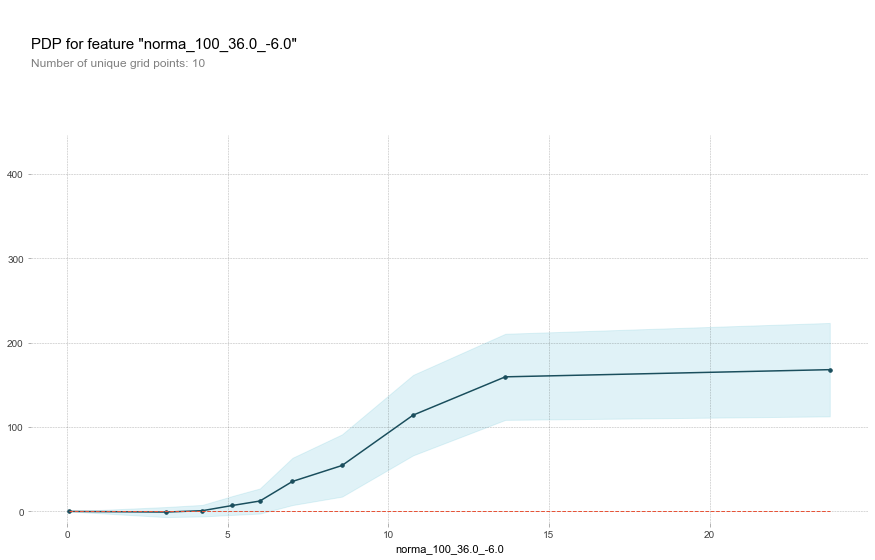

In [9]:
# 'norma_100_36.0_-6.0' most important variable according permutation test
# Create the data that we will plot
pdp_norma_100 = pdp.pdp_isolate(model=gb11, dataset=x_test, model_features=feature_names, feature='norma_100_36.0_-6.0')

# plot it
pdp.pdp_plot(pdp_norma_100, 'norma_100_36.0_-6.0')
plt.show()

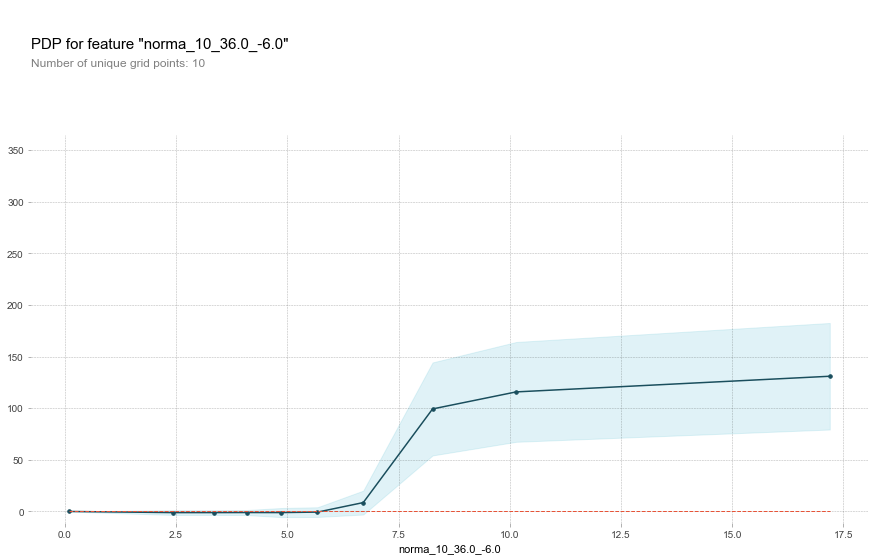

In [10]:
# 2nd most important variable according to permutation test
pdp_u100 = pdp.pdp_isolate(model=gb11, dataset=x_test, model_features=feature_names, feature='norma_10_36.0_-6.0')

pdp.pdp_plot(pdp_u100, 'norma_10_36.0_-6.0')
plt.show()

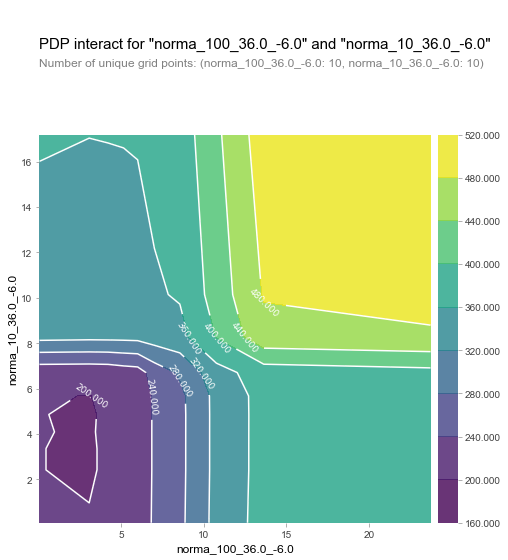

In [11]:
# Interaction between them 

pdp_inter = pdp.pdp_interact(model=gb11, dataset=x_test, model_features=feature_names, features=['norma_100_36.0_-6.0','norma_10_36.0_-6.0'])

pdp.pdp_interact_plot(pdp_interact_out = pdp_inter, feature_names = ['norma_100_36.0_-6.0','norma_10_36.0_-6.0'], plot_type = 'contour')
plt.show()

### SHAP values 

In [12]:
data_for_prediction = x_train.iloc[20]

In [13]:
data_for_prediction

norma_10_36.0_-5.0     9.689547
norma_10_36.0_-5.5     8.166180
norma_10_36.0_-6.0     9.809698
norma_10_36.0_-6.5    11.397927
norma_10_36.5_-5.0     5.168047
                        ...    
v100_36.5_-6.5        -0.460810
v100_37.0_-5.0         5.108907
v100_37.0_-5.5         3.041378
v100_37.0_-6.0        -1.474328
v100_37.0_-6.5        -2.409749
Name: 20, Length: 96, dtype: float64

In [14]:
data_for_prediction.values.reshape(1, -1).shape

(1, 96)

In [15]:
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

gb11.predict(data_for_prediction_array)

array([614.78752976])

In [16]:
explainer = shap.TreeExplainer(gb11)
shap_values = explainer.shap_values(data_for_prediction)

In [17]:
shap_values

array([ 1.40339864e+00,  8.57449039e+00,  1.09220632e+02,  1.44562693e+00,
       -7.46825064e-02, -6.34230565e+00, -3.70907887e+01, -8.35085797e-01,
       -1.36914229e+00,  1.47928513e-01, -1.12463024e-01, -2.59441601e-02,
        1.65590749e+00,  2.22385328e+01,  1.51658263e+02, -5.62412312e-02,
        2.69310902e+00,  6.82744552e+00, -2.66392261e+00, -9.60363171e-02,
        1.48672642e+00, -7.83600388e-01,  3.15306934e-01,  2.70800241e-01,
        1.43414093e+00,  1.29129592e-01, -1.72213518e+00, -3.29801322e+00,
        4.94439933e+00,  6.58670285e-02, -2.50118369e+00,  1.66773463e+00,
       -3.87308376e+00, -7.48008416e+00, -2.21742069e+00,  6.08318708e-01,
        1.08950621e+00, -2.13935010e+00, -1.14185626e+00,  4.88584917e+00,
        6.99022156e+00,  1.21978695e+00, -5.34859432e+00, -5.72792233e-01,
       -1.43983639e-01, -1.13691852e+00, -1.50621573e+00, -7.12421774e-01,
        1.89688688e+00,  1.56065178e+01,  4.83804814e+00,  8.98141670e-01,
        1.92675095e+00, -

In [18]:
explainer.expected_value

array([335.71042468])

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

### Summary Plots

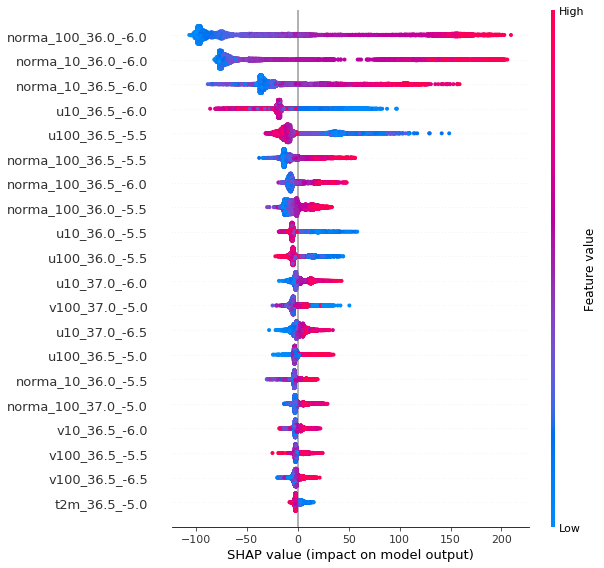

In [20]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(gb11)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(x_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, x_test)

### SHAP Dependence Contribution Plots

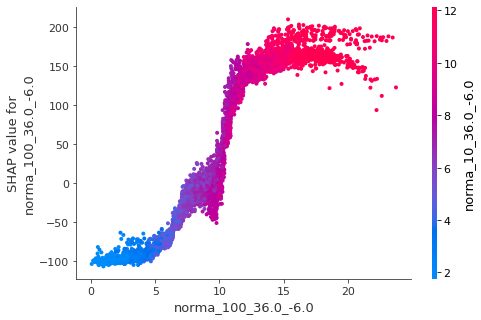

In [21]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(gb11)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(x_test)

# make plot.
shap.dependence_plot('norma_100_36.0_-6.0', shap_values, x_test, interaction_index="norma_10_36.0_-6.0")